In [314]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [315]:
#Reading the data as a pandas DataFrame
df = pd.read_csv('drive/MyDrive/ML Projects/Time Series Forecasting Notebooks/RSCCASN.csv', parse_dates=['DATE']).set_index(['DATE'])
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [316]:
#We have 349 data points that correspond to monthly values from 1992 to 2020
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 349 entries, 1992-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  349 non-null    int64
dtypes: int64(1)
memory usage: 5.5 KB


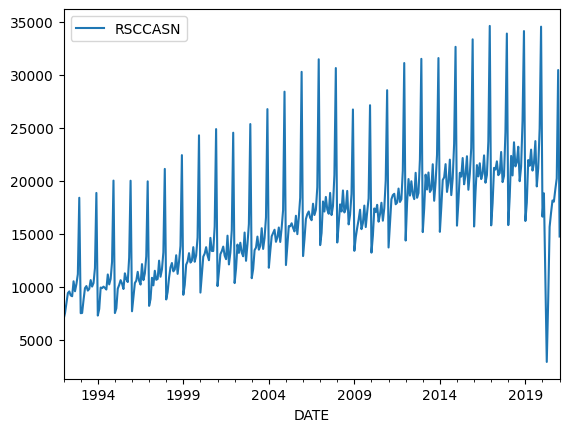

In [317]:
#Plotting the data
df.plot();

As we can see, the COVID-19 pandemic produced a strong deviation in the pattern of the series in 2020. Because no model trained on past data will be able to predict the occurrence of the pandemic, we will be working with data up to 2019.

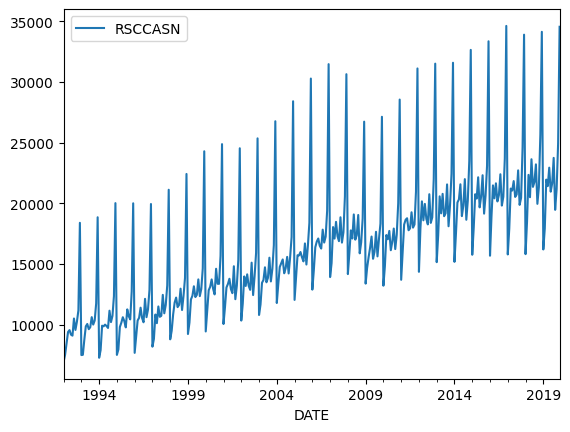

In [318]:
#Taking only the data from 1992 to 2019
df = df['1992':'2019']
df.plot();

## Data preparation

Before we create any model for predicting this series, it is important to split the data into train and test sets. Because this is a time series problem, these sets can't be random points in the series; instead, they must contain data from one point in time to another. In this case, the dataset was split as follows:

TRAIN SET: everything from the original set except the last two years

TEST SET: the last two years of the original set

Therefore, the forecasting models will predict two years into the future.

In [319]:
#defining the point of the split between train and test sets
split_point = len(df)-24

In [320]:
#splitting the dataset
train_df = df[:split_point]
test_df = df[split_point:]
print(train_df.shape, test_df.shape)

(312, 1) (24, 1)


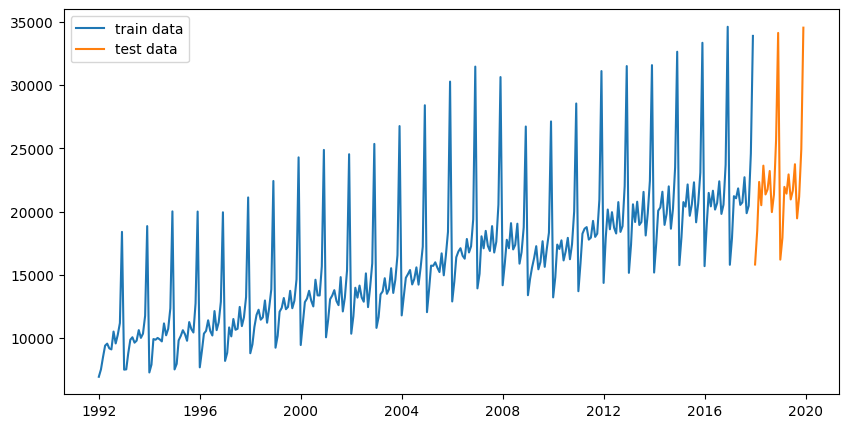

In [321]:
#plotting the training and test sets
plt.figure(figsize=(10,5))
plt.plot(train_df, label='train data')
plt.plot(test_df, label='test data')
plt.legend();

## Naive forecasting

Before creating a forecasting model, it is important to have a baseline to compare our model's performance. These baselines are called naive forecasting, and although they are based on simple assumptions, they can produce better results than more sophisticated models.

In this case, we will leverage the seasonality of the time series to create a seasonal naive forecast. This means that our prediction will be akin to saying that the predicted season will be the same as the one before it. Because our seasons correspond to cicles of 12 months, we will say that the values of the next 12 months will be those of the previous 12. This means that for 2018, the predictions will correspond to the actual values from 2017, and for 2019, the predictions will be the real values from 2018.

In [322]:
#creating the naive forecasts by taking the values of the 2018 and 2017 seasons
naive_forecast = pd.concat([train_df[-12:], test_df[:12]])

In [323]:
#Creating the naive forecast using the last season as a predictor
test_df['naive_forecast'] = naive_forecast.to_numpy()

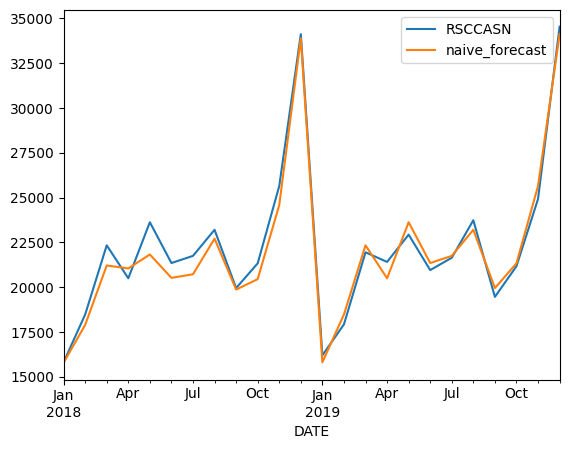

In [324]:
#Visualizing the naive forecast and the actual values
test_df.plot();

## SARIMA model

Now that the dataset is ready, it is possible to create forecasting models. The first one will be a Seasonal Autoregressive Integrated Moving Average (SARIMA) model, one of the most widely used statistical models in time series forecasting. The selection of this model is explained in this section.

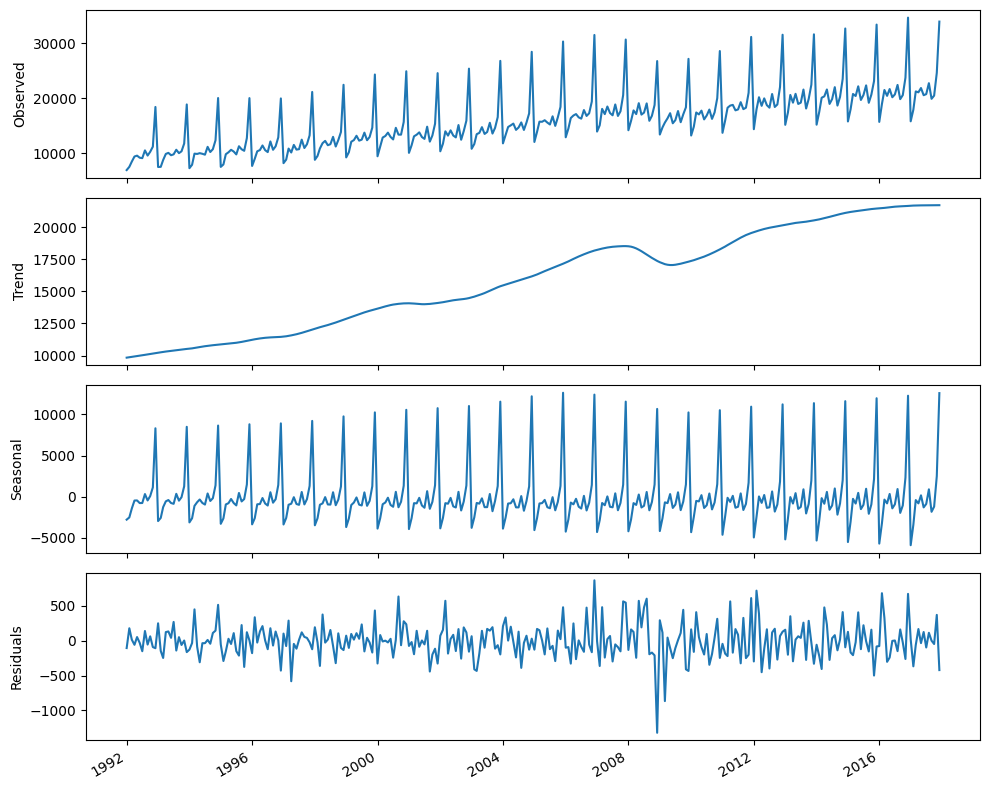

In [325]:
#Before creating the model, we first need to analyze the following components of the series: trend, seasonality, and residuals
#We can do this with the statsmodels library
from statsmodels.tsa.seasonal import STL
decomposer = STL(train_df, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))
ax1.plot(decomposer.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposer.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposer.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposer.resid)
ax4.set_ylabel('Residuals')
fig.autofmt_xdate()
plt.tight_layout()

From the decomposition plots we can observe that the data has a continous rising trend and a clear seasonality that repeats every 12 months. This information is important because it tells us that we will need to use a model that considers these two aspects, which is why the model chosen is a SARIMA model. The seasonal (S) and integrated (I) aspects of the SARIMA model respectively account for these two components.

With this defined, we need to find the (p,d,q) and (P,D,Q)s values. The s value is already determined; it is 12 because we are working with monthly data in a yearly basis, and there are 12 months in a year. For the other values, we need to be working with a stationary series. Therefore, we will verify whether the time series is stationary, and if it isn't we will apply transformations to make it stationary.

In [144]:
#Verifying that the series is stationary with an Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
#For the series to be stationary, the first value has to be a large negative number and the second (p-value) must be below 0.05
#These values show that the series is not stationary
adfuller(train_df)[:2]

(-0.8162374382314723, 0.8143058516362134)

In [327]:
#differencing to transform the series into a stationary one
#Since we are applying 12th order differencing, this means that D=12
train_df_diff = train_df.diff(periods=12).dropna()

In [328]:
#After differencing, now the series is stationary.
adfuller(train_df_diff)[:2]

(-4.007561646251967, 0.001371429741191581)

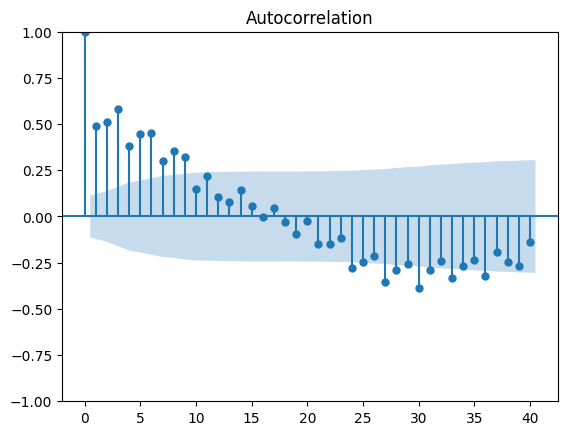

In [147]:
#plotting the acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_df_diff, lags=40);

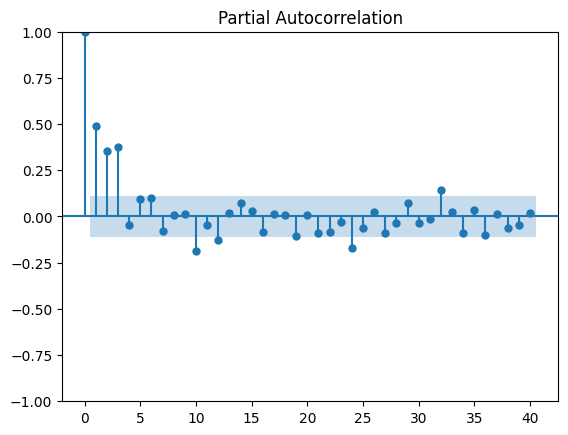

In [148]:
#plotting the pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_df_diff, lags=40);

Since the PACF plot gave us a more interpretable result, we will use it to define the p and P values. The non-seasonal p will be taken as 3 because there are three significant spikes at lags 1,2, and 3. The seasonal P will be taken as 2 because there are two significant spikes at lags 12 and 24.

In [149]:
ps = [3]
qs = range(0, 5, 1)
Ps = [2]
Qs = range(0,5,1)
d = 0
D = 1
s = 12

In [150]:
from itertools import product
SARIMA_order_list = list(product(ps,qs,Ps,Qs))

To find the optimal p, q, P, and Q values, we will iteratively try different combinations and calculate the Akaike information criterion (AIC). This is a mathematical method for evaluating how well a model fits the data it was generated from. The best model is the one with the lowest AIC score. To do this, we use custom the function created below.

In [151]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [152]:
#trying out different models
SARIMA_result_df = optimize_SARIMA(train_df, SARIMA_order_list, d, D, s)

  0%|          | 0/25 [00:00<?, ?it/s]

In [308]:
#Observing the results
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(3, 4, 2, 4)",4656.535420
1,"(3, 3, 2, 4)",4657.337735
2,"(3, 1, 2, 4)",4666.113016
3,"(3, 0, 2, 4)",4666.571739
4,"(3, 2, 2, 4)",4667.560202
5,"(3, 1, 2, 2)",4667.837545
6,"(3, 2, 2, 3)",4671.165296
7,"(3, 0, 2, 2)",4671.513684
8,"(3, 2, 2, 2)",4673.264929
9,"(3, 3, 2, 2)",4674.524178


In [154]:
#After trying out different combinations, this is the optimal model found
SARIMA_model = SARIMAX(train_df, order=(3,0,4), seasonal_order=(2,1,4,12)).fit(dips=False)

In [155]:
#predicting RSCCASN for 2018 and 2019
SARIMA_predictions = SARIMA_model.predict('2018','2019-12')

In [156]:
SARIMA_predictions

2018-01-01    15713.462153
2018-02-01    18585.204394
2018-03-01    21672.674362
2018-04-01    21196.974360
2018-05-01    22524.557417
2018-06-01    20737.963668
2018-07-01    21053.808719
2018-08-01    23345.056330
2018-09-01    20143.883247
2018-10-01    20943.690886
2018-11-01    25114.995339
2018-12-01    34501.087584
2019-01-01    16176.517495
2019-02-01    19180.844809
2019-03-01    22064.538042
2019-04-01    21686.056540
2019-05-01    23153.403720
2019-06-01    21041.025471
2019-07-01    21661.445455
2019-08-01    23897.569346
2019-09-01    20441.520062
2019-10-01    21599.679505
2019-11-01    25528.050696
2019-12-01    35078.720899
Freq: MS, Name: predicted_mean, dtype: float64

In [157]:
test_df['SARIMA_forecast'] = SARIMA_predictions

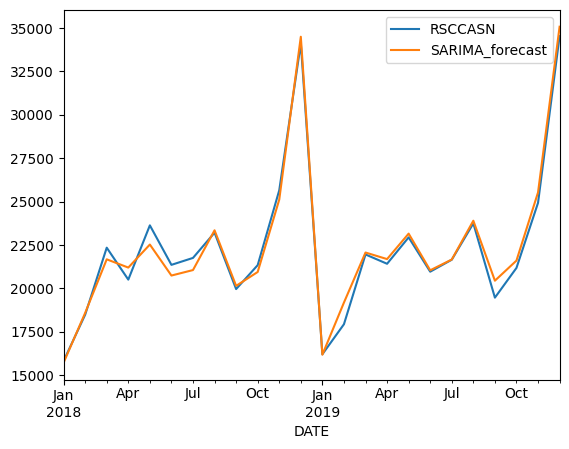

In [160]:
test_df[['RSCCASN','SARIMA_forecast']].plot();

Now, let's compare the predictions of the SARIMA model with those of the Naive forecast.

In [159]:
from sklearn.metrics import mean_absolute_error
naive_mae = mean_absolute_error(test_df['RSCCASN'],test_df['naive_forecast'])
SARIMA_mae = mean_absolute_error(test_df['RSCCASN'],test_df['SARIMA_forecast'])
print('Naive average error:', f'{naive_mae}')
print('SARIMA average error:', f'{SARIMA_mae}')

Naive average error: 602.2083333333334
SARIMA average error: 428.2246008615577


The SARIMA model outperformed the naive forecast bya considerable margin, although both methods show a considerably low error.

## Forecasting the series with LSTM cells

In this section, we will use the TensorFlow library to create a neural network with long short-term memory (LSTM) cells that can forecast the retail sales serioes. The first step for this is to scale the dataset and create the sequences (windows) that will be fed into the model.

### Scaling the data and creating windows

In [311]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_df)
scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df['RSCCASN'].to_numpy().reshape(len(test_df),1))

In [262]:
#creating windows of 12 values (one year)
train_data = tf.keras.utils.timeseries_dataset_from_array(scaled_train,
                                                             targets=scaled_train[12:],
                                                             sequence_length=12,
                                                             batch_size=1)
test_data = tf.keras.utils.timeseries_dataset_from_array(scaled_test,
                                                             targets=scaled_test[12:],
                                                             sequence_length=12,
                                                             batch_size=1)

In [312]:
#Our inputs are batches of 12 values that the model will use to predict the next value
print('input shape:', next(train_data.as_numpy_iterator())[0].shape)
print('output shape:', next(train_data.as_numpy_iterator())[1].shape)

input shape: (1, 12, 1)
output shape: (1, 1)


### Building and training the model



In [310]:
#Creating an early stopping callback
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae',
                                         patience=40,
                                         verbose=1,
                                         restore_best_weights=True)

In [287]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
tf.random.set_seed(0)
model = Sequential()
model.add(LSTM(120, activation= 'relu', input_shape=[None,1], return_sequences=True))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse', metrics='mae')
hist = model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[es_cb], verbose=1)

Epoch 1/500
300/300 [==============================] - 8s 20ms/step - loss: 0.0194 - mae: 0.0918 - val_loss: 0.0143 - val_mae: 0.0786
Epoch 2/500
300/300 [==============================] - 3s 9ms/step - loss: 0.0071 - mae: 0.0558 - val_loss: 0.0067 - val_mae: 0.0578
Epoch 3/500
300/300 [==============================] - 5s 15ms/step - loss: 0.0039 - mae: 0.0417 - val_loss: 0.0029 - val_mae: 0.0325
Epoch 4/500
300/300 [==============================] - 3s 9ms/step - loss: 0.0023 - mae: 0.0334 - val_loss: 0.0016 - val_mae: 0.0271
Epoch 5/500
300/300 [==============================] - 3s 9ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 9.9963e-04 - val_mae: 0.0226
Epoch 6/500
300/300 [==============================] - 4s 12ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 6.6251e-04 - val_mae: 0.0194
Epoch 7/500
300/300 [==============================] - 4s 12ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 4.9958e-04 - val_mae: 0.0172
Epoch 8/500
300/300 [==============================] 

In [309]:
#Evaluating the model on the test data
model.evaluate(test_data)

12/12 [==============================] - 0s 7ms/step - loss: 3.6684e-04 - mae: 0.0150


[0.0003668436547741294, 0.014992836862802505]

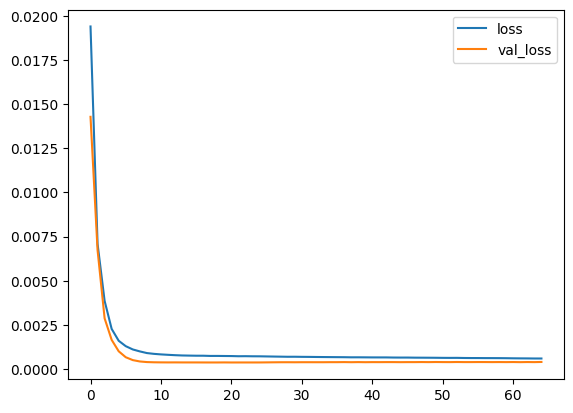

In [306]:
#Plotting loss and val_loss during training
pd.DataFrame(hist.history)[['loss','val_loss']].plot();

### forecasting with the neural network
Making predictions with the created mode is not as simple as with the SARIMA model. In this case, because we are only predicting one value at the time (this is the way we set up the network) we must predict one value, then add that value to the next window to make the next prediction. We will create a function that does this.

In [289]:
WINDOW = 12 #the same number that we used when training the model (a year of data)
HORIZON = 24 #the number of values to predict (two years)
def forecast(model, dataset, window=12, horizon=12):
  predictions = []
  input = dataset[-window:]
  for i in range(horizon):
    prediction = model.predict(input, verbose=0)[0]
    predictions.append(prediction[0][0])
    input = np.append(input[1:,:],prediction, axis=0)
  return np.array(predictions)

In [290]:
LSTM_preds = forecast(model,scaled_train, WINDOW, HORIZON)
transformed_preds = scaler.inverse_transform(LSTM_preds.reshape(len(LSTM_preds),1))

In [291]:
test_df['LSTM_preds'] = transformed_preds

<Axes: xlabel='DATE'>

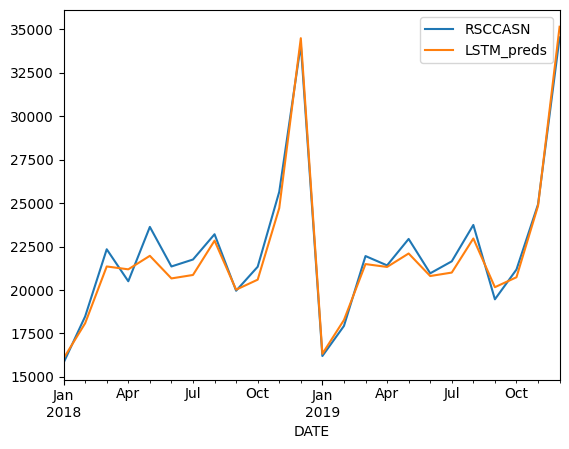

In [292]:
test_df[['RSCCASN','LSTM_preds']].plot()

## Model Comparison

In [293]:
#Calculating the prediction error
LSTM_mae = mean_absolute_error(test_df['RSCCASN'], test_df['LSTM_preds'])
print('Naive average error:', f'{naive_mae}')
print('SARIMA average error:', f'{SARIMA_mae}')
print('LSTM average error:', f'{LSTM_mae}')

Naive average error: 602.2083333333334
SARIMA average error: 428.2246008615577
LSTM average error: 554.5861409505209


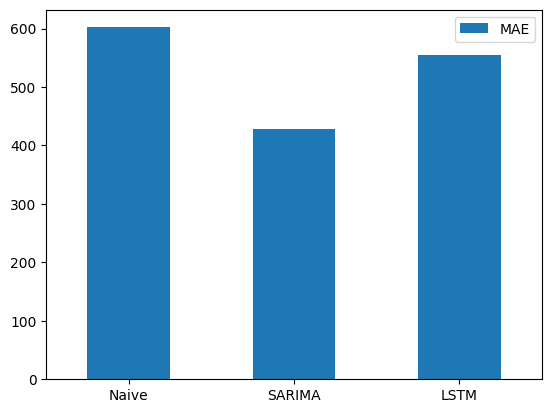

In [304]:
#Model comparison
pd.DataFrame({'MAE':[naive_mae,SARIMA_mae,LSTM_mae]}, index=['Naive','SARIMA','LSTM']).plot(kind='bar');
plt.xticks(rotation=0);

Out of the three forecasting methods applied, the one with the best performance was the SARIMA model, followed by the LSTM and the Naive method. It is expected for the SARIMA model to have the best performance because it excels when working with data that shows high regularity, such as the one that was worked on in this notebook. Deep learning methods such as LSTMs are better suited for forecasting more complex series with vast amounts of data.